## Pandas IV: Aggregation, Grouping and Pivot Tables

*Disclaimer: The contents of this notebook are developped according to Python Data Science Handbook, by Jake VanderPlas and Python for Data Analysis, by Wes McKinney*

In [ ]:
import numpy as np
import pandas as pd

An essential piece of analysis of large data is efficient summarization: computing aggregations like `sum()`, `mean()`, `median()`, `min()`, and `max()`, in which a single number gives insight into the nature of a potentially large dataset. In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a `groupby`

### Simple Aggregation in Pandas
As with a one-dimensional NumPy `array`, for a Pandas `Series` the aggregates return a single value

In [ ]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

In [ ]:
ser.sum()

In [ ]:
np.sum(ser)

In [ ]:
ser.mean()

In [ ]:
np.mean(ser)

**For a `DataFrame`, by default the aggregates return results within each column**

In [ ]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

In [ ]:
df.mean()

In [ ]:
# In a future version, DataFrame.mean(axis=None) 
# will return a scalar mean over the entire DataFrame
df.mean(axis=None)

In [ ]:
np.mean(df.values)

In [ ]:
np.mean(df)

By specifying the `axis` argument, you can instead aggregate within each row

In [ ]:
df.mean(axis = 'columns')

Pandas `Series` and `DataFrames` include all of the common aggregates mentioned earlier. In addition, there is a convenience method `describe()` that computes several common aggregates for each column and returns the result. Let's use this on the Planets data from seaborn, for now dropping rows with missing values

In [ ]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

In [ ]:
planets.head()

In [ ]:
planets.isnull().any()

In [ ]:
planets.info()

In [ ]:
planets.dropna().describe()

In [ ]:
# DataFrame.count: Count number of non-NA/null observations
planets.describe()

The following table summarizes some other built-in Pandas aggregations. These are all methods of `DataFrame` and `Series` objects

<div>
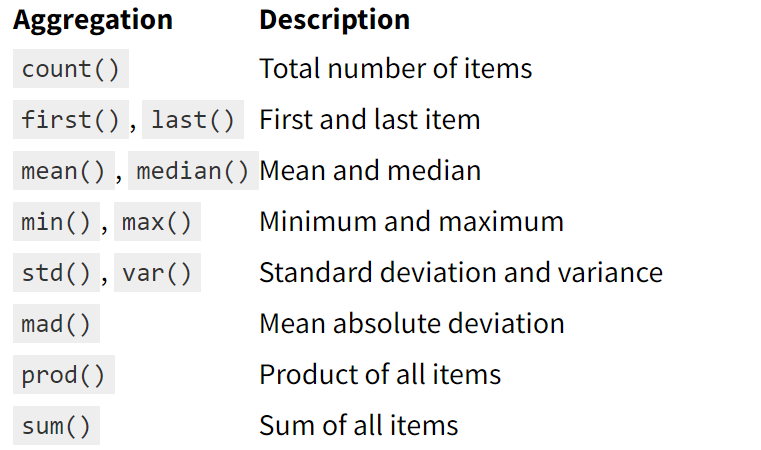
</div>

### GroupBy: Split, Apply, Combine
Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called groupby operation.
    
The figure below makes clear what the `groupby` accomplishes

<div>
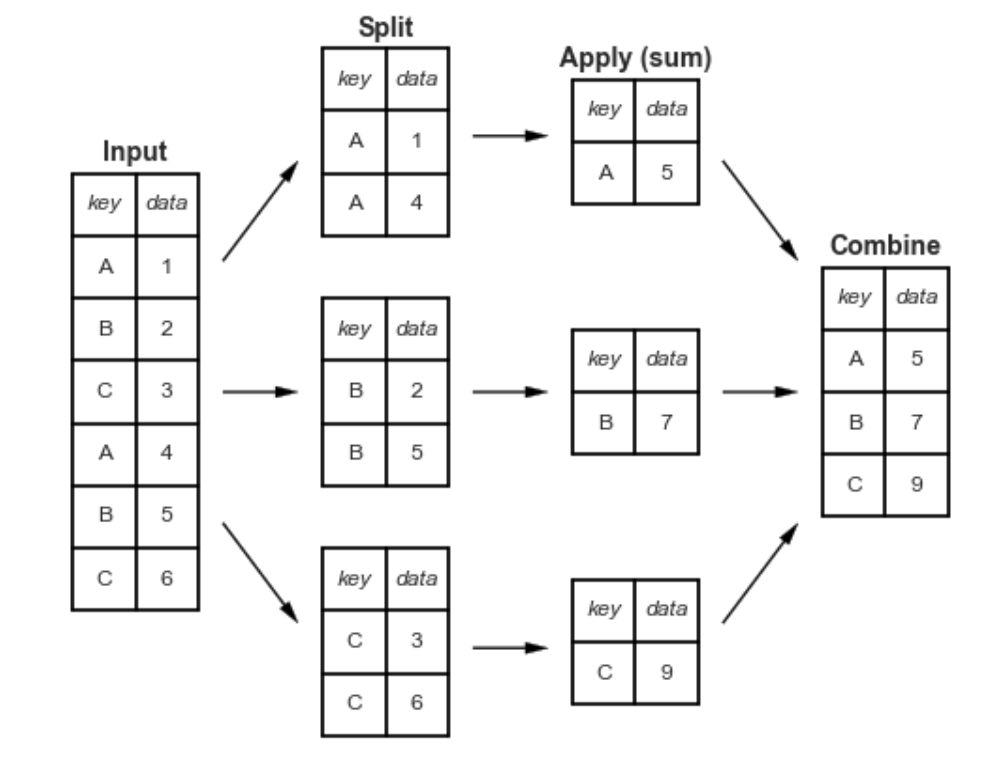
</div>

- The split step involves breaking up and grouping a `DataFrame` depending on the value of the specified `key`
- The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups
- The combine step merges the results of these operations into an output array

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram. We'll start by creating the input `DataFrame`

In [ ]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns = ['key', 'data'])
df

The most basic split-apply-combine operation can be computed with the `groupby()` method of `DataFrames`, passing the name of the desired `key` column

In [ ]:
df.groupby('key')

Notice that what is returned is not a set of `DataFrames`, but a `DataFrameGroupBy` object. This object is where the magic is: you can think of it as a special view of the `DataFrame`, which is poised to dig into the groups but does no actual computation until the aggregation is applied.

To produce a result, we can apply an aggregate to this `DataFrameGroupBy` object, which will perform the appropriate apply/combine steps to produce the desired result. **The keys (column) we are grouping by will be placed in the index**

In [ ]:
df.groupby('key').sum()

The `sum()` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid `DataFrame` operation

### The GroupBy Object
The `GroupBy` object is a very flexible abstraction. In many ways, you can simply treat it as if it's a collection of `DataFrames`, and it does the difficult things under the hood. The most important operations made available by a GroupBy are aggregate, filter, transform, and apply.

#### Column Indexing
Since we can treat the `GroupBy` object as a collections of DataFrames, supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object

In [ ]:
planets['method'].value_counts()

In [ ]:
planets.groupby('method')

In [ ]:
planets.groupby('method')['orbital_period']

Here we've selected a particular `Series` group from the original `DataFrame` group by reference to its column name. As with the `GroupBy` object, no computation is done until we call some aggregate on the object

In [ ]:
planets.groupby('method')['orbital_period'].median()

#### Iteration Over Groups
The `GroupBy` object supports direct iteration over the groups, returning each group as a `Series` or `DataFrame`. The `Groupby` object generates a sequence of 2-tuples containing the group name along with the chunk of the data (a new DataFrame)

In [ ]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape = {1}\n {2}".format(method, group.shape, group))

In [ ]:
# retrieve a group using get_group
planets.groupby('method').get_group('Imaging')

In [ ]:
# property with dictionary mapping group name to list of index values
planets.groupby('method').groups

#### Dispatch Methods
Any common Pandas or NumPy aggregation functions, as well as any valid Pandas `Series` and `DataFrame` operation can be applied the `GroupBy` object. For example, you can use the `describe()` method of DataFrames to perform a set of aggregations that describe each group in the data

In [ ]:
planets.groupby('method')['year'].describe()

Notice that the operations are applied to each individual group, and the results are then combined within `GroupBy` and returned. Again, any valid `DataFrame/Series` method can be used on the corresponding `GroupBy` object, which allows for some very flexible and powerful operations!

#### Aggregation
We're now familiar with `GroupBy` aggregations with `sum()`, `median()`, and the like, but the `aggregate()` method allows for even more flexibility. It can take a string, a function, or a list thereof, and compute all the aggregates at once.

> ```python
DataFrame.aggregate(func = None, axis = 0, *args, **kwargs)

- `func`: Function to use for aggregating the data. Accepted combinations are: function, string function name, list of functions and/or function names, e.g. `[np.sum, 'mean']`, dict of axis labels -> functions, function names or list of such
- `axis`: {0 or ‘index’, 1 or ‘columns’}, default 0. If 0 or ‘index’: apply function to each column. If 1 or ‘columns’: apply function to each row

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key1': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'key2': ['foo', 'bar', 'foo', 'foo', 'bar', 'bar'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key1', 'key2', 'data1', 'data2'])
df

In [ ]:
df.groupby('key1').aggregate(['min', np.median, max])

You may have noticed that there is no `key2` column in the result because `key2` column contains non-numeric data. By default, all of the numeric columns (e.g., `data1` and `data2`) are aggregated.

As you can also see, the resulting `DataFrame` has hierarchical column indexes. You do not need to accept the names that `Groupby` gives to the columns. If you pass a list of `(name, function)` tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping)

In [ ]:
df.groupby('key1').agg([('foo', 'min'), ('bar', np.median), ('baz', max)])

We can also group data using multiple keys

In [ ]:
df.groupby(['key1', 'key2']).mean()

In [ ]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)
    print()

In the case of multiple keys, the first element in the tuple will be a tuple of key values

In [ ]:
# retrieve a particular group
df.groupby(['key1', 'key2']).get_group(('A', 'foo'))

By default, `groupby` groups by rows on `axis = 0`, you can group on any of the other axes. For example, we could group the columns of our example `df` here by `dtype`

In [ ]:
df.dtypes

In [ ]:
grouped = df.groupby(df.dtypes, axis = 1) # key length is the same as column numbers

In [ ]:
for k, group in grouped:
    print(k)
    print(group)
    print()

Another useful pattern is to pass a `dictionary` mapping column names to operations to be applied on that column

In [ ]:
df.groupby('key1').aggregate({'data1': 'min',
                             'data2': 'max'})

In [ ]:
df.groupby('key1').aggregate({'data1': ['min', 'mean', 'std'],
                             'data2': 'max'})

**A `DataFrame` will have hierarchical column indexes only if multiple functions are applied to at least one column**. In all of the examples up until now, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations. You can disable this behavior by passing `as_index = False` to `groupby`

In [ ]:
df.groupby('key1').mean()

In [ ]:
df.groupby('key1', as_index =  False).mean()

#### Filtering
A filtering operation allows you to drop data based on the group properties. It returns a copy of a DataFrame excluding filtered elements. Elements from groups are filtered if they do not satisfy the boolean criterion specified by `func`. For example, we might want to keep all groups in which the standard deviation is larger than some critical value. 

> ```python
DataFrameGroupBy.filter(func, dropna=True, *args, **kwargs)
```

In [ ]:
def filter_func(x):
    # x represents a dataframe
    return x['data2'].std() > 4

df

In [ ]:
df.groupby('key1').std()

`df.groupby('key')` is just syntactic sugar for `df.groupby(df['key'])`

In [ ]:
df.groupby('key1').filter(filter_func)

In [ ]:
df.groupby('key1').filter(lambda x: x['data2'].std() > 4)

**The filter function should return a Boolean value specifying whether the group passes the filtering**. Here because group A does not have a standard deviation greater than 4, it is dropped from the result

### `apply`: General Split-Apply-Combine
The most general purpose `Groupby` method is `apply`. It lets you apply an arbitray function to the group results. What occurs inside the function passed to `apply` is up to you. It only needs to return a Pandas object or a scalar value. Please keep in mind that the input argument of the function passed to `apply` is a DataFrame. **Please do not be confused with the Series and DataFrame's `apply` method**

- Series's `apply`: the input of the function passed to the `apply` is each value in the Series
- DataFrame's `apply`: the input of the function passed to the `apply` is each row (`axis = 1`) or column (`axis = 0`) of the DataFrame
- Groupby's `apply`: the input of the function passed to the `apply` is a DataFrame

Let's use the tips dataset from Seaborn as an example

In [ ]:
import seaborn as sns
tips = sns.load_dataset('tips')
tips.head()

In [ ]:
tips.info()

After loading the dataset, we add a tipping percentage column tip_pct

In [ ]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

Suppose you wanted to select the top five tip_pct values by group. First, write a function that selects the rows with the largest values in a particular column

In [ ]:
# pay attention to the function argument, it must receive a DataFrame
def top(df, n = 5, column = 'tip_pct'):
    #return df.sort_values(by = column)[-n:]
    return df.loc[df[column].nlargest(n).index]
top(tips, n = 3)

Now, if we group by smoker and call `apply` with this function

In [ ]:
tips.groupby('smoker').apply(top)

The `top` function is called on each row group from the DataFrame, and then the results are glued together, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the orginal DataFrame. In the preceding example, you can see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each pieces of the original DataFrame. You can disbale this by passing `group_keys = False` to `groupby`

In [ ]:
tips.groupby('smoker', group_keys = False).apply(top)

In [ ]:
tips.groupby('smoker', as_index = False).apply(top)

If you pass a function to `apply` that takes other arguments or keywords, you can pass these after the function

In [ ]:
tips.groupby(['smoker', 'day']).apply(top, n = 2, column = 'total_bill')

### Specifying the Split Key
In the simple examples presented before, we split the `DataFrame` on a single column name. This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here

#### A List, Array, Series, or Index Providing the Grouping Keys
The key can be any `Series` or list with a length matching that of the `DataFrame`

In [ ]:
df

In [ ]:
# three new group keys, 0, 1 and 2
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

#### A Dictionary or Series Mapping Index to Group
Another method is to provide a `dictionary` that maps index values to the group keys. A `dictionary` or `Series`, providing a `label -> group name` mapping

In [ ]:
df2 = df.set_index('key1')
df2

In [ ]:
# combine B and C into one group
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
df2.groupby(mapping).sum()

#### Any Python Function
Similar to mapping, you can pass any Python function that will use the DataFrame's index values as input and output the group keys (Any function passed as a group key will be called once per index value, with the return values being used as the group names)

In [ ]:
df2

In [ ]:
df2.groupby(str.lower).mean()

#### A List of Valid Keys
Further, any of the preceding key choices can be combined to group on a multi-index

In [ ]:
df2.groupby([str.lower, mapping]).mean()

### Grouping by Index Levels
A final convenience for hierarchically indexed datasets is the ability to aggregate using one of the levels of an axis index

In [ ]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names = ['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns = columns)
hier_df

To group by level, pass the level number or name using the `level` option

In [ ]:
# count of non-missing values for each column or row per group
hier_df.groupby(level = 'cty', axis = 1).count()

Regardless of the objective in using `groupby`, a generally useful groupby method is `size`, which returns a `Series` containing group sizes (the number of rows/columns in each group)

In [ ]:
# DataFrameGroupBy method returns a series with size of each group
hier_df.groupby(level='cty', axis=1).size()

### A Grouping Example
As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade

In [ ]:
planets.head()

In [ ]:
decade = 10 * (planets['year'] // 10)
decade

In [ ]:
# DataFrame.astype(dtype, copy=True, errors='raise')
# Cast a pandas object to a specified dtype
decade = decade.astype(str) + 's'
decade

In [ ]:
decade.name = 'decade'
decade

In [ ]:
result = planets.groupby(['method', decade])['number'].sum()
result

In [ ]:
result.unstack()

### Pivot Tables
The pivot table takes simple **column-wise** data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data

For the examples in this section, we'll use the database of passengers on the Titanic, available through the Seaborn library

In [ ]:
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head()

Let's look at survival rate by gender by using the `GroupBy` method we studies in the previous section

In [ ]:
titanic.groupby('sex')[['survived']].mean()

We might like to go one step deeper and look at survival by both sex and, say, class. Using the vocabulary of `GroupBy`, we might proceed using something like this: we group by class and gender, select survival, apply a mean aggregate, combine the resulting groups, and then unstack the hierarchical index to reveal the hidden multidimensionality

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

In [ ]:
titanic.groupby(['sex', 'class'])[['survived']].aggregate('mean')

This two-dimensional `GroupBy` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multi-dimensional aggregation

### Pivot Table Syntax

> ```python
pd.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)

- `data`: DataFrame
- `values`: column to aggregate, optional
- `index`: column, Grouper, array, or list of the previous. If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table index. If an array is passed, it is being used as the same manner as column values
- `columns`: column, Grouper, array, or list of the previous. If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table column. If an array is passed, it is being used as the same manner as column values
- `aggfunc`: function, list of functions, dict, default numpy.mean. If list of functions passed, the resulting pivot table will have hierarchical columns whose top level are the function names (inferred from the function objects themselves) If dict is passed, the key is column to aggregate and value is function or list of functions
- `margins`: bool, default False. Add all row / columns (e.g. for subtotal / grand totals).
- `dropna`: bool, default True. Do not include columns whose entries are all NaN
    
**The `index` and `columns` are mostly from the categorical columns.** Here is the equivalent to the preceding operation using the `pivot_table` method of DataFrames

In [ ]:
pd.pivot_table(titanic, 'survived', index = 'sex', columns = 'class')

In [ ]:
titanic.pivot_table('survived', index = 'sex', columns = 'class')

In [ ]:
titanic.pivot_table(['survived', 'fare'], index = 'sex', columns = 'class')

This is eminently more readable than the groupby approach, and produces the same result

### Multi-level Pivot Tables
Just as in the `GroupBy`, the grouping in pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. We'll bin the age using the `pd.cut` function

In [ ]:
# pandas.cut(x, bins, right=True)
# Bin values into discrete intervals
# x: The input array to be binned. Must be 1-dimensional
# bins: The criteria to bin by
# right: Indicates whether bins includes the rightmost edge or not. 
# If right == True (the default), then the bins [1, 2, 3, 4] indicate (1,2], (2,3], (3,4]. 

age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

In [ ]:
age

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using `pd.qcut` to automatically compute quantiles

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

The result is a four-dimensional aggregation with hierarchical indices, shown in a grid demonstrating the relationship between the values.

### Additional Pivot Table Options
We've already seen examples of the `pivot_table` by using `values`, `index` and `columns` parameters; here we'll take a quick look at the remaining ones. Two of the options, `fill_value` and `dropna`, have to do with missing data and are fairly straightforward.

The `aggfunc` keyword controls what type of aggregation is applied, which is a mean by default. As in the `GroupBy`, the aggregation specification can be a string representing one of several common choices (e.g., `'sum'`, `'mean'`, `'count'`, `'min'`, `'max'`, etc.) or a function that implements an aggregation (e.g., `np.sum()`, `min()`, `sum()`, etc.). Additionally, it can be specified as a `dictionary` mapping a column to any of the above desired options

In [ ]:
titanic.pivot_table(index = 'sex', columns = 'class',
                    aggfunc = {'survived':sum, 'fare':'mean'})

Notice also here that we've omitted the `values` keyword; when specifying a mapping for `aggfunc`, this is determined automatically by the dictionary keys

At times it's useful to compute totals along each grouping. This can be done via the `margins` keyword

In [ ]:
titanic.pivot_table('survived', index = 'sex', columns = 'class', margins = True)

### Crosstab
A cross-tabulation is a special case of a pivot table that computes group frequencies. It computes a simple cross tabulation of two (or more) factors. By default computes a frequency table of the factors unless an array of values and an aggregation function are passed

> ```python
pd.crosstab(index, columns, values = None, rownames = None, colnames = None, aggfunc = None, margins = False, margins_name = 'All', dropna = True, normalize = False)

- `index`: Values to group by in the rows
- `columns`: Values to group by in the columns. Unlike `pivot_table()`, this parameter is not optional

In [ ]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
data

In [ ]:
pd.crosstab(data.Nationality, data.Handedness, margins = True)

In [ ]:
data1 = data.pivot_table(index = 'Nationality', columns = 'Handedness', aggfunc = 'count', margins = True)
data1

In [ ]:
data1 = data.pivot_table(values='Sample', index = 'Nationality', columns = 'Handedness', aggfunc = 'count', margins = True)
data1

### Case Study: Movie Rating
Let's first load the dataset

In [ ]:
df = pd.read_csv(
    'ratings.dat',
    sep = '::',
    engine = 'python', 
    names = 'UserID::MovieID::Rating::Timestamp'.split('::')
)
df.head()

In [ ]:
df.info()

Next we will calcuate the average rating for each movie

In [ ]:
result = df.groupby('MovieID')['Rating'].mean()
result.head()

Next we will calculate the average, highest and lowest ratings for each movie

In [ ]:
# method 1
result = df.groupby('MovieID')['Rating'].agg(['mean', 'max', ('min', np.min)]
)
result.head()

In [ ]:
# method 2
result = df.groupby("MovieID").agg(
    {'Rating':['mean', 'max', np.min]}
)
result.head()

In [ ]:
result.columns = ['mean', 'max', 'min']
result.head()

Finally, we will get the total number of people who rated each movie, plus each movie's average, highest and lowest ratings

In [ ]:
# method 1
result = df.groupby("MovieID").agg(
        rating_mean = ("Rating", "mean"),
        rating_min = ("Rating", "min"),
        rating_max = ("Rating", "max"),
        user_count = ('UserID', lambda x : x.nunique())
)
result.head()

In [ ]:
# method 2
result = df.groupby("MovieID").agg(
    {
        "Rating": ['mean', 'min', 'max'],
        "UserID": lambda x :x.nunique()
    }
)
result.head()

In [ ]:
result.columns = ['rating_mean', 'rating_min', 'rating_max', 'user_count']
result.head()

In [ ]:
# method 3
def agg_func(x):
    # x is a DataFrame
    
    # this Series will become a row of the resulting DataFrame，Key of the dict becomes the column name
    return pd.Series({
        'rating_mean': x['Rating'].mean(),
        'rating_min': x['Rating'].min(),
        'rating_max': x['Rating'].max(),
        'user_count': x['UserID'].nunique()
    })

result = df.groupby('MovieID').apply(agg_func)
result.head()

In [ ]:
index1= pd.to_datetime(df['Timestamp'])

In [ ]:
type(index1[0])

In [ ]:
df.index = index1
df.head()

### Case Study: Birthrate Data
Let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC). This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv 

In [ ]:
# download the data
!curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [ ]:
births = pd.read_csv('births.csv')
births.head()

In [ ]:
births.info()

In [ ]:
births[births['day'].isnull()]

 Let's add a decade column, and take a look at male and female births as a function of decade

In [ ]:
births['decade'] = 10 * (births['year'] // 10)
births

In [ ]:
births.loc[:, 'decade'] = 10 * (births['year'] // 10)
births

In [ ]:
births.pivot_table('births', index = 'decade', columns = 'gender', aggfunc = 'sum')

We immediately see that male births outnumber female births in every decade. To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # use Seaborn styles
births.pivot_table('births', index = 'year', columns = 'gender', aggfunc = 'sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and `plot()` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%

#### Removing Outliers
Next we start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th). One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation

In [ ]:
# numpy.percentile(a, q) returns an array
# a: Input array
# q: Percentile or sequence of percentiles to compute, which must be between 0 and 100 inclusive
# find the 25%, 50% and 75% percentiles
quartiles = np.percentile(births['births'], [25, 50, 75])
quartiles

In [ ]:
pd.qcut(births['births'], [0.25, 0.50, 0.75])

In [ ]:
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

With this we can use the `query()` method to filter-out rows with births outside these values

In [ ]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
births

In [ ]:
type(births['day'][0])

Next we set the `day` column to integers

In [ ]:
# set 'day' column to integer
births['day'] = births['day'].astype(int)

In [ ]:
births.loc[:, 'day'] = births['day'].astype(int)

In [ ]:
type(births['day'][0])

Finally, we can combine the day, month, and year to create a Date index . This allows us to quickly compute the weekday corresponding to each row

In [ ]:
# create a datetime index from the year, month, day
# datetimeIndex https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
#births.index = pd.to_datetime(10000 * births.year +
#                              100 * births.month +
#                              births.day, format = '%Y%m%d')

births.index = pd.PeriodIndex(year=births['year'], month=births['month'], day=births['day'], freq='D')

# Monday = 0, ..., Sunday = 6
births['dayofweek'] = births.index.dayofweek
births

Using this we can plot births by weekday for several decades

In [ ]:
births.pivot_table('births', index = 'dayofweek',
                    columns = 'decade', aggfunc = 'mean')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index = 'dayofweek',
                    columns = 'decade', aggfunc = 'mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

Another intersting view is to plot the mean number of births by the day of the year. Let's first group the data by month and day separately

In [ ]:
# without specifying column names
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

The result is a multi-index over months and days. To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [ ]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year. From this, we can use the plot method to plot the data. It reveals some interesting trends

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(births_by_date)